Load libraries

In [13]:
import os
import time
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

Extract simplified road network of the City of London and plot.

In [14]:
query = 'City of London, United Kingdom'

In [15]:
g = ox.graph_from_place(query, network_type='all_private', simplify=True, retain_all=False, truncate_by_edge=False, 
                 which_result=None, buffer_dist=None, clean_periphery=True, custom_filter=None)

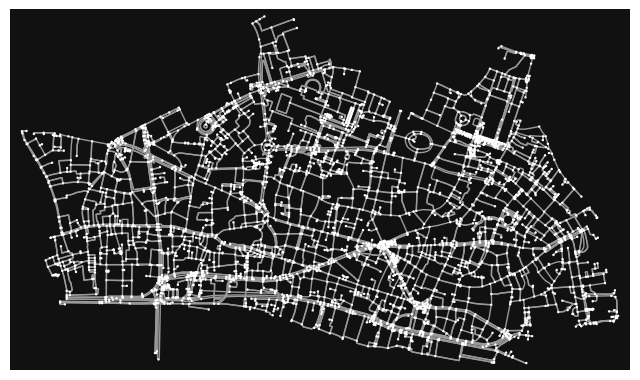

In [16]:
ox.plot.plot_graph(g, ax=None, figsize=(8, 8), bgcolor='#111111', node_color='w', node_size=3, 
                      node_alpha=None, node_edgecolor='none', node_zorder=1, edge_color='#999999', 
                      edge_linewidth=1, edge_alpha=None, show=True, close=False, save=False, 
                      filepath=None, dpi=300, bbox=None);

In [17]:
# reset multi index
nodes, edges = ox.graph_to_gdfs(g)
nodes.reset_index(inplace = True)
edges.reset_index(inplace = True)

In [18]:
#| include: false
# from loaded graph, generate an edgelist file and save locally
nx.write_edgelist(g, os.path.relpath("lon.edgelist"))

In [19]:
#| include: false
# open the edgelist as a list
with open(os.path.relpath("lon.edgelist")) as f:
    elist = []
    for item in f:
        elist.append(item)
edf = pd.DataFrame(elist)
edf.head()

,0
0,"104318 7946372941 {'osmid': 57042810, 'lanes':..."
1,"104318 1596648671 {'osmid': [851939645, 106807..."
2,"104318 25509527 {'osmid': [1068072014, 1068072..."
3,"104319 7946378610 {'osmid': 851938705, 'highwa..."
4,"104319 2398924898 {'osmid': [49780459, 1065099..."


In [20]:
#| include: false
# # convert list to pandas dataframe and clean columns
edf = pd.DataFrame(elist)
edf = edf[0].str.split('{', expand=True)
ijw = edf[0].str.split(expand=True)
edf = edf[1].str.split('length', expand=True)
edf = edf[1].str.split(expand=True)
edf = edf[1].str.split(',', expand=True)
edf = edf[0].str.split('}', expand=True)
ijw['w'] = edf[0]
ijw.columns = ['i', 'j', 'w']
#ijw.set_index('i', inplace = True)
ijw.to_csv(os.path.relpath("londonijw.csv"), index=False)
ijw.head()

,i,j,w
0,104318,7946372941,3.667
1,104318,1596648671,58.759
2,104318,25509527,24.883000000000003
3,104319,7946378610,2.012
4,104319,2398924898,53.068000000000005


In [21]:
#| include: false

# define percolation function
def run_spercolation(input_path, output_path, ps):
    """
    Function that runs the street percolation.
    
    input_path: path of the edgelist file in the format (i,j,w)
    output_path: desideredpath for the output files
    ps: array of percolation thresholds
    """
    
    #################### Preparing output folders

    #directory for membership tables
    dir_res_memb = output_path+'/membTables/' 
    if not os.path.exists(dir_res_memb): os.makedirs(dir_res_memb)

    #directory for cluster size tables    
    dir_clust_size = output_path+"/cluster_sizes/"
    if not os.path.exists(dir_clust_size): os.makedirs(dir_clust_size)
        
    #directory for cluster diameter tables   ###### 
    dir_clust_diam = output_path+"/cluster_diameters/"
    if not os.path.exists(dir_clust_diam): os.makedirs(dir_clust_diam)
        
    #file with global threshold info
    clusters_info_filename = output_path+"/clusters_info_p.txt"

    
    ########################################
    
    
    #Let us read the file that contains the list of nodes
    edgelist = pd.read_csv(input_path, sep=",")
    edgelist.columns = ['start_point','end_point','length']
    
    #Creating a file with global info on clusters given threshold p
    clusters_info_file = open(clusters_info_filename,'w')
    header = "threshold_p,n_clusters,LCC_id,LCC_size\n"
    clusters_info_file.write(header)
    
    for p in ps:
        #print('p=', p)
    
        #find sub-matrix such that all weights <= threshold p
        filtered_p = edgelist[edgelist['length']<=p]
        #print 'filtered'
    
        #create graph
        G = nx.from_pandas_edgelist(filtered_p, source='start_point', target='end_point', edge_attr='length',
                                create_using=nx.Graph())
        #print 'graph created'
        #nx.draw(G)
        
        #Creating a membership table file
        file_name = dir_res_memb+'membership_'+'p'+str(p)+'.txt'
        memb_table_file = open(file_name,'w')
        header = "node_id,cluster_id\n"
        memb_table_file.write(header)

        #Creating a cluster size file
        file_name = dir_clust_size+'clust_size_'+'p'+str(p)+'.txt'
        cluster_size_file = open(file_name,'w')
        header = "cluster_id,cluster_size\n"
        cluster_size_file.write(header)
        
        #Creating a cluster diameter file ########
        file_name = dir_clust_diam+'clust_diam_'+'p'+str(p)+'.txt'
        cluster_diam_file = open(file_name,'w')
        header = "cluster_id,cluster_diam\n"
        cluster_diam_file.write(header)

        #Looping over connected components
        LCC_size = 0 #initial value to store the size of the LCC
        LCC_id = None
        for cluster_id, cluster_nodes in enumerate(nx.connected_components(G)):

            #Saving cluster size to file
            cluster_size = len(cluster_nodes)
            line = "%i,%i\n"%(cluster_id, cluster_size)
            cluster_size_file.write(line)

            #Updating the value for the size of the LCC (I want to find the id)
            if cluster_size>LCC_size:
                LCC_size = cluster_size
                LCC_id = cluster_id

            #Looping over nodes in clusters and saving to membership table file 
            for n in cluster_nodes:
                line = "%i,%i\n"%(n,cluster_id)
                memb_table_file.write(line)
                
            g = G.subgraph(cluster_nodes)
            cluster_diam = nx.diameter(g)
            line = "%i,%i\n"%(cluster_id, cluster_diam)
            cluster_diam_file.write(line)
            
        #Saving global clusters info to file
        NCC = cluster_id+1 #last id index +1 since it started from 0
        line = str(p)+',%i,%i,%i\n'%(NCC,LCC_id,LCC_size)
        clusters_info_file.write(line)
        #print(NCC, 'connected components\n')

        memb_table_file.close()
        cluster_size_file.close()
        cluster_diam_file.close() ######

    clusters_info_file.close()

    return None

In [22]:
#| echo: false
input_path = os.path.relpath("londonijw.csv")
output_path = os.path.relpath("perc")
ps = np.arange(1, 101, 1, dtype=int)
ps

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [23]:
#| include: false

#run_spercolation(input_path, output_path, ps):
#start_time = time.time()
#run_spercolation(input_path, 
#                 output_path, 
#                 ps)
#print("--- %s seconds ---" % (time.time() - start_time))

KeyboardInterrupt: 

Plot evolution of largest cluster size to view the percolation behaviour of the City of London. 

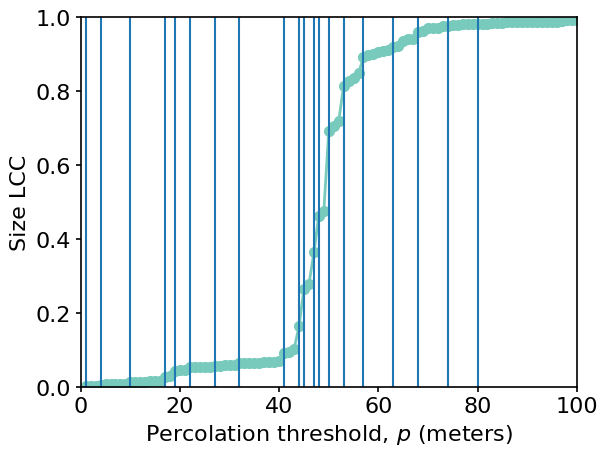

In [28]:
# Plot percolation
fig, ax = plt.subplots()

#Reading data
clusters_info_filename = output_path + "/clusters_info_p.txt"
info = pd.read_csv(clusters_info_filename)

x = info['threshold_p']
y = info['LCC_size']/3994 # g.number_of_nodes() #info['LCC_size'].max()

#Plotting
import matplotlib.ticker as ticker
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2

rangec = np.linspace(0.2,0.95,5)
colors = [plt.cm.YlGnBu(i) for i in rangec]

ax.plot(x, y,'o-', markersize=7, color=colors[1], clip_on=True, mfc=colors[1],
    mec=colors[1], lw=2, label='Size LCC')

plt.xlim([0, 100])
plt.ylim([0, 1])

ax.set_xlabel(r'Percolation threshold, $p$ (meters)', size=16)
ax.set_ylabel('Size LCC', size=16)
ax.tick_params(axis='both', which='both', labelsize=16)

xcoords = [1, 4, 10, 17, 19, 22, 27, 32, 41, 44, 45, 47, 48, 50, 53, 57, 63, 68, 74, 80]
for xc in xcoords:
    plt.axvline(x=xc)
    
#plt.savefig("SiteBond/figs/lcc")

Plot percolation processes at selected thresholds.

/Users/yun/Documents/portfolio/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


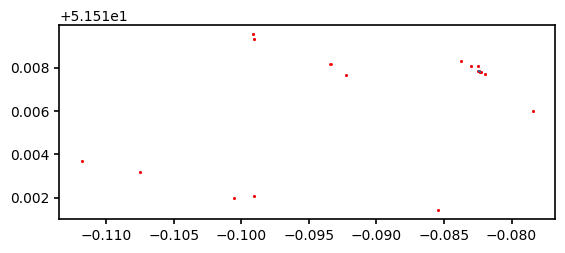

/Users/yun/Documents/portfolio/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


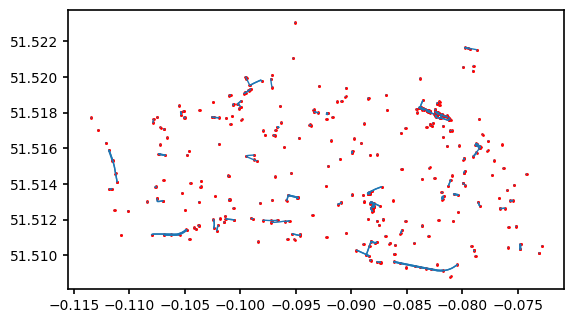

/Users/yun/Documents/portfolio/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


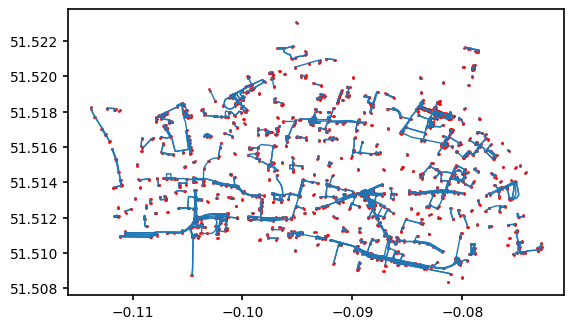

/Users/yun/Documents/portfolio/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


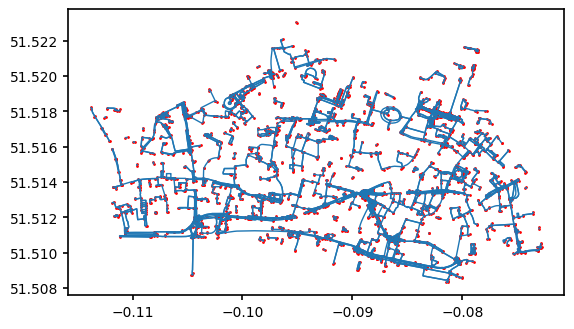

/Users/yun/Documents/portfolio/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


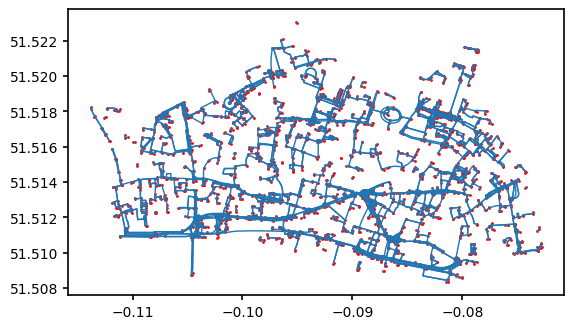

/Users/yun/Documents/portfolio/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


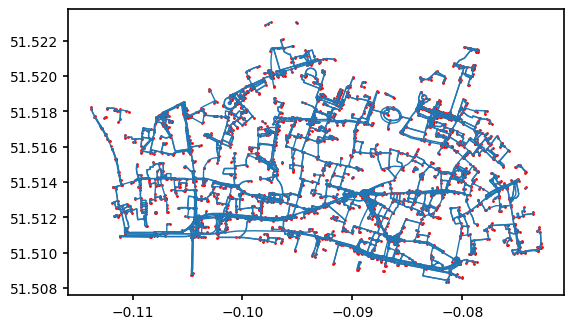

/Users/yun/Documents/portfolio/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


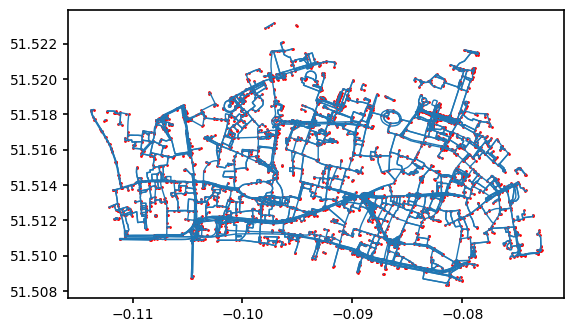

/Users/yun/Documents/portfolio/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


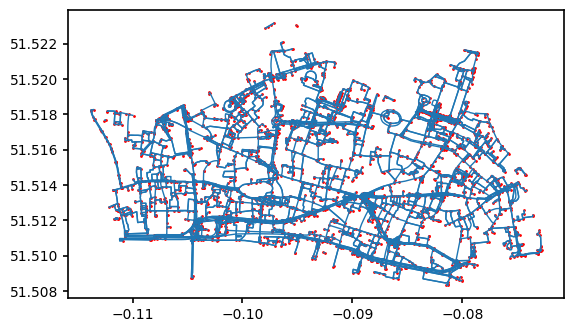

/Users/yun/Documents/portfolio/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


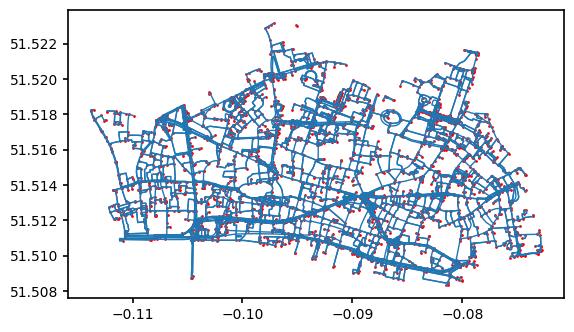

/Users/yun/Documents/portfolio/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


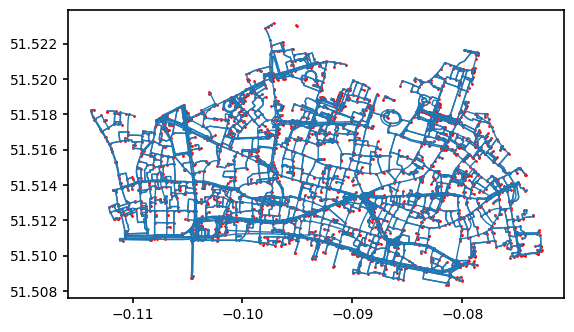

/Users/yun/Documents/portfolio/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


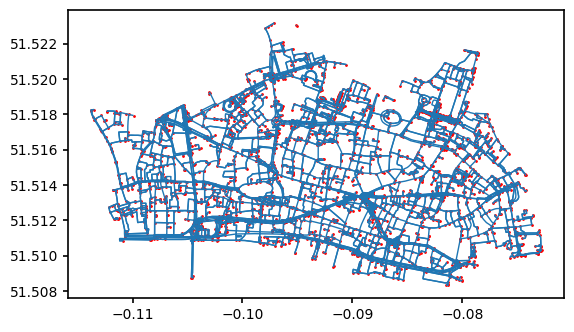

/Users/yun/Documents/portfolio/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


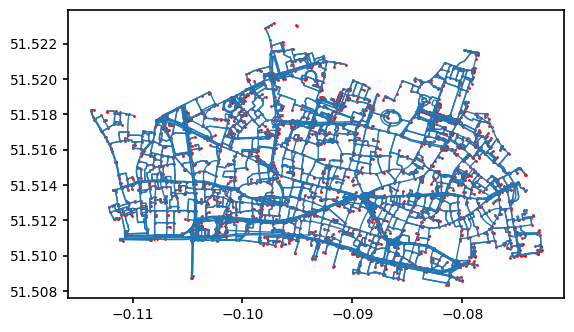

/Users/yun/Documents/portfolio/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


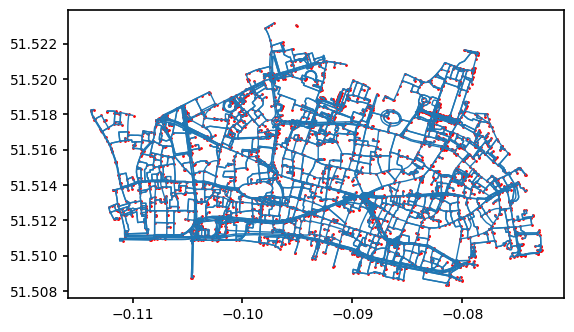

/Users/yun/Documents/portfolio/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


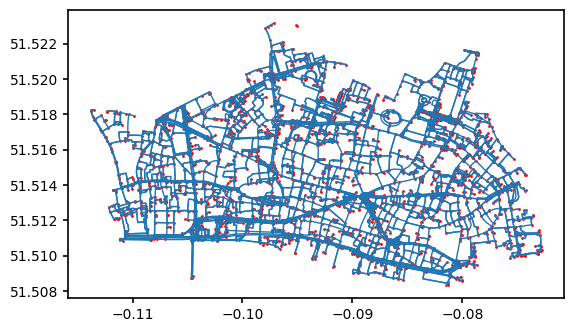

/Users/yun/Documents/portfolio/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


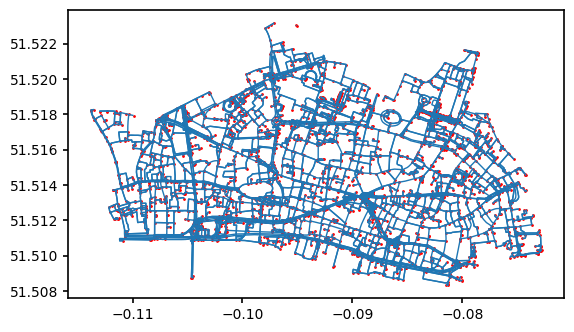

/Users/yun/Documents/portfolio/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


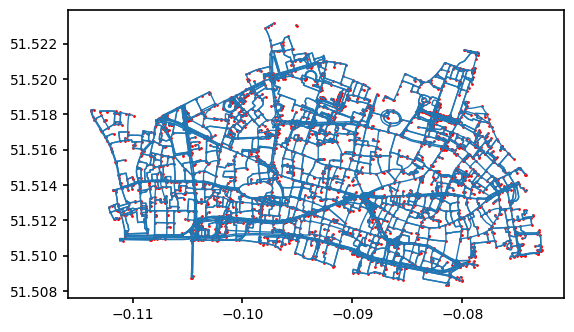

/Users/yun/Documents/portfolio/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


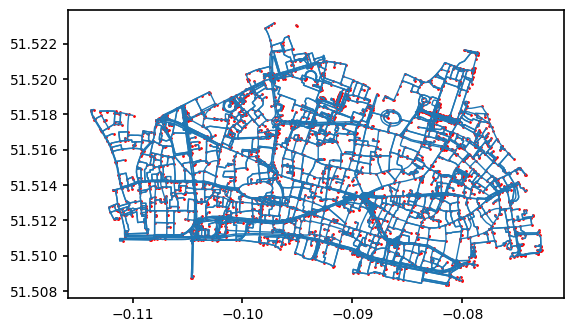

/Users/yun/Documents/portfolio/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


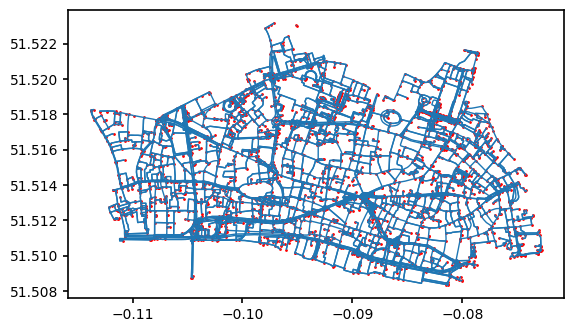

/Users/yun/Documents/portfolio/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


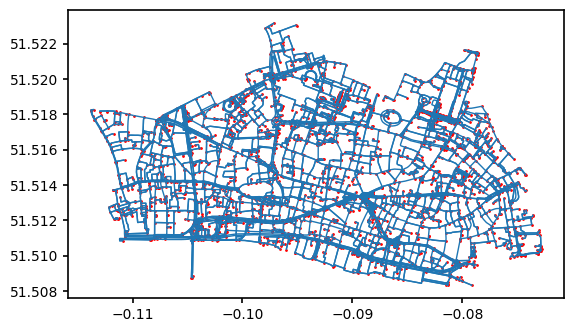

/Users/yun/Documents/portfolio/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


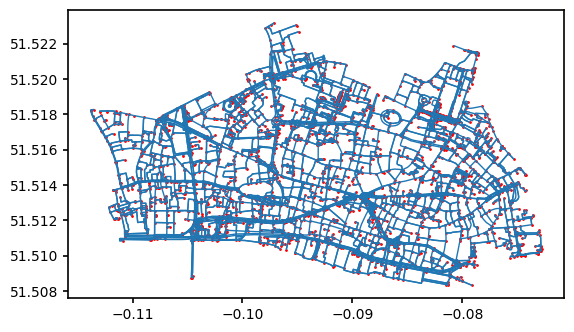

In [31]:
dir_res_memb = output_path+'/membTables/' 
#print(dir_res_memb)
#for p in list(reversed(ps)):

for p in xcoords:
    file_name = dir_res_memb+'membership_'+'p'+str(p)+'.txt'
    #print(file_name)
    memb_table_file = pd.read_csv(file_name)
    #memb_table_file.head()
    nodes = pd.merge(nodes, memb_table_file, how='left', left_on='osmid', right_on='node_id', suffixes=(None, '_'+str(p)))
    edges["up"] = [p if u in list(memb_table_file.node_id) else 'NA' for u in edges["u"]]
    edges["vp"] = [p if v in list(memb_table_file.node_id) else 'NA' for v in edges["v"]]
    nodes["p"] = [p if osmid in list(memb_table_file.node_id) else 'NA' for osmid in nodes["osmid"]]

    fig, ax = plt.subplots()
    nodes[nodes["p"]==p].plot(ax=ax, markersize=1, color='red');
    edges[edges["up"]==p][edges["vp"]==p].plot(ax=ax, linewidth=1);
    #plt.savefig("SiteBond/figs/lon_"+str(p), dpi=300)
    plt.show();
    
# bond percolation... but size is with intersections instead of edges

In [ ]:
#| include: false
ox.plot.plot_graph(g, ax=None, figsize=(8, 8), bgcolor='#111111', node_color='w', node_size=3, 
                      node_alpha=None, node_edgecolor='none', node_zorder=1, edge_color='#999999', 
                      edge_linewidth=1, edge_alpha=None, show=True, close=False, save=False, 
                      filepath=None, dpi=300, bbox=None)

In [ ]:
#| include: false
fig, ax = plt.subplots()
for x in xcoords:
    nodes[nodes.cluster_id_8.notna()==True].plot(ax=ax, color = 'purple')
    nodes[nodes.cluster_id_5.notna()==True].plot(ax=ax, color = 'blue')
    nodes[nodes.cluster_id_4.notna()==True].plot(ax=ax, color = 'green')
    nodes[nodes.cluster_id_3.notna()==True].plot(ax=ax, color = 'yellow')
    nodes[nodes.cluster_id_2.notna()==True].plot(ax=ax, color = 'orange')
    nodes[nodes.cluster_id_1.notna()==True].plot(ax=ax, color = 'darkred')

In [ ]:
#| include: false
fig, ax = ox.plot_graph(g, figsize = (10, 10), bgcolor='white', node_color = 'blue', 
                        node_size = 1, edge_linewidth=1)
#ox.save_graph_geopackage(G, os.path.relpath('Data/G.gpkg'), encoding='utf-8')